## 3 서술자 문장 유사도 분석

TF-IDF 점수는 작가가 반복적으로 강조한 단어나 주제를 추려내는 데 유용함 / 이제는 대사와 서술을 구분해봄


In [ ]:
import re

# 대사 패턴 정의: 큰따옴표 또는 구어체 문장 끝 표현
def classify_sentence_type(text):
    text = str(text).strip()
    
    # 패턴 1: 큰따옴표/말줄임표/인용부호 등으로 감싼 문장
    if re.match(r'^["\'“‘].+["\'”’]$', text):
        return "대사"
    
    # 패턴 2: 구어체 말투로 끝나는 문장
    if re.search(r'(했어|했네|했지|하네|하군|하오|합네|했구먼|말이오|말여|하요|하지요|하시지요|하자구요|했구요|하네그려)[.!?"]?$', text):
        return "대사"
    
    # 나머지 → 서술
    return "서술"

# 적용
df["문장형태"] = df["문장내용"].apply(classify_sentence_type)


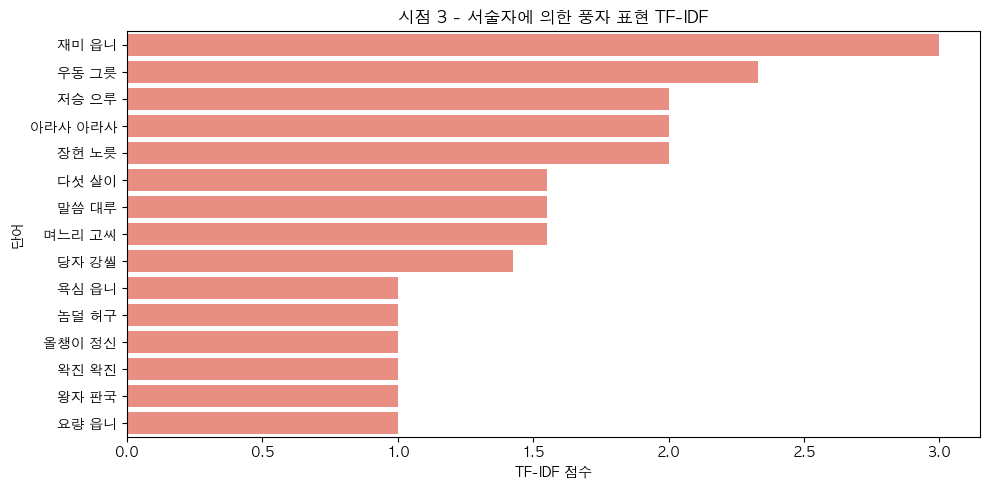

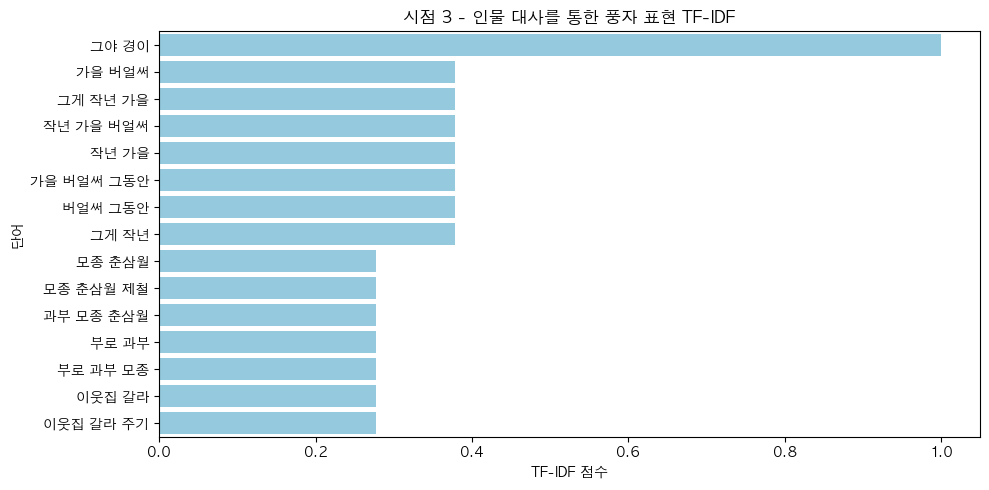

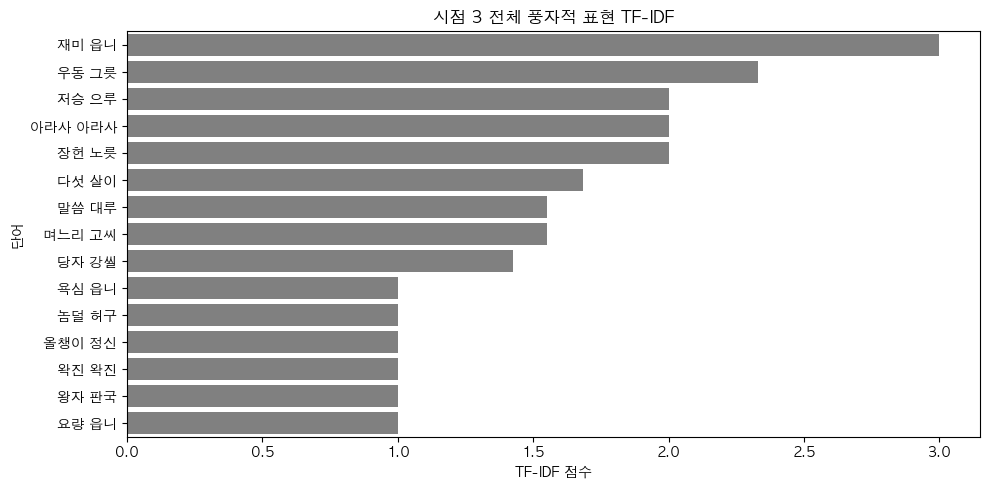

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 0. 불용어 확장 + 명사 기반 필터 함수
custom_stopwords = stopwords.union(set(["윤직", "영감", "양복", "신사", "그놈", "그자", "그년"]))

def clean_noun_tokens(text):
    tokens = okt.pos(text, stem=True)
    return [word for word, tag in tokens if tag == "Noun" and word not in custom_stopwords]

# 1. 시점 3 범위 필터링
df_s3 = df[(df["문장번호"] >= 1101) & (df["문장번호"] <= 3654)].dropna(subset=["문장내용", "감정유형", "문장형태"])

# 2. 풍자적 표현 포함한 문장만 추출 (반어, 조롱, 과장 포함)
df_s3_satire = df_s3[df_s3["감정유형"].str.contains("반어|조롱|과장", na=False)].copy()

# 3. 명사 기반 토큰화
df_s3_satire["tokens"] = df_s3_satire["문장내용"].apply(clean_noun_tokens)
df_s3_satire["joined"] = df_s3_satire["tokens"].apply(lambda x: " ".join(x))
df_s3_satire = df_s3_satire[df_s3_satire["joined"].str.strip() != ""]

# 4. 문장형태에 따라 분리
satire_quot = df_s3_satire[df_s3_satire["문장형태"] == "대사"]
satire_desc = df_s3_satire[df_s3_satire["문장형태"] == "서술"]

# 5. TF-IDF 함수 정의
def get_top_ngrams(docs, ngram_range=(2, 3), max_features=100):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=1, max_features=max_features)
    X = vectorizer.fit_transform(docs)
    tfidf_scores = pd.Series(X.toarray().sum(axis=0), index=vectorizer.get_feature_names_out()).sort_values(ascending=False)
    return tfidf_scores

# 6. 각각 TF-IDF 분석
satire_total_tfidf = get_top_ngrams(df_s3_satire["joined"])
satire_desc_tfidf = get_top_ngrams(satire_desc["joined"])
satire_quot_tfidf = get_top_ngrams(satire_quot["joined"])

# 7. 시각화 (서술자 풍자 표현)
plt.figure(figsize=(10, 5))
sns.barplot(x=satire_desc_tfidf.values[:15], y=satire_desc_tfidf.index[:15], color="salmon")
plt.title("시점 3 - 서술자에 의한 풍자 표현 TF-IDF")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()

# 8. 시각화 (인물 대사를 통한 풍자 표현)
plt.figure(figsize=(10, 5))
sns.barplot(x=satire_quot_tfidf.values[:15], y=satire_quot_tfidf.index[:15], color="skyblue")
plt.title("시점 3 - 인물 대사를 통한 풍자 표현 TF-IDF")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()

# 9. 전체 풍자 문장 기준 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=satire_total_tfidf.values[:15], y=satire_total_tfidf.index[:15], color="gray")
plt.title("시점 3 전체 풍자적 표현 TF-IDF")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()


시점 3 기준으로 서술자 vs 인물대사 

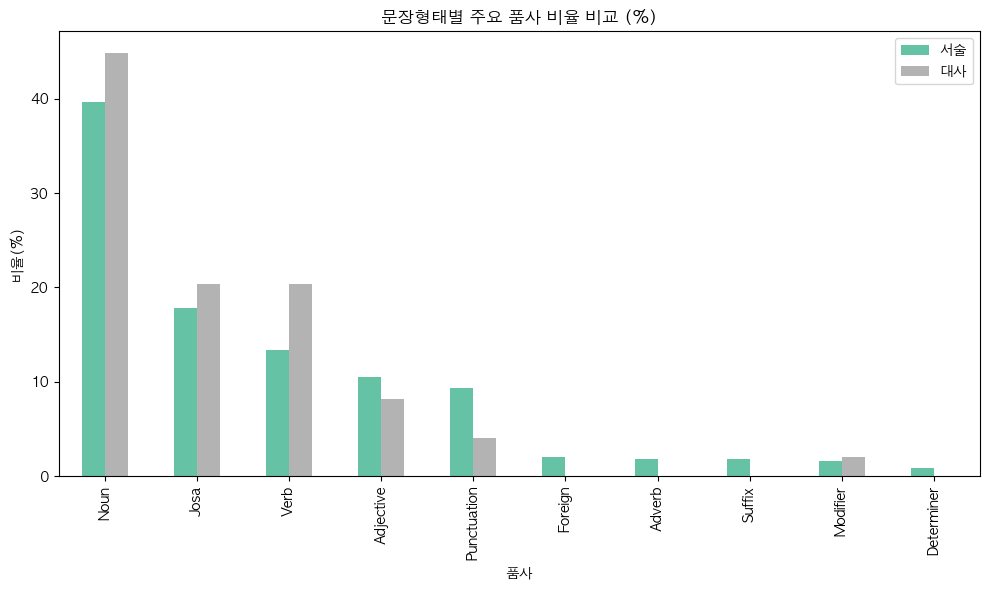

In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 품사 추출 함수
def extract_pos_list(text):
    return [tag for _, tag in okt.pos(text, stem=True)]

# 2. 서술/대사 문장만 추출
desc_texts = df_s3_satire[df_s3_satire["문장형태"] == "서술"]["문장내용"].tolist()
quot_texts = df_s3_satire[df_s3_satire["문장형태"] == "대사"]["문장내용"].tolist()

# 3. 품사 추출
desc_pos = [tag for text in desc_texts for tag in extract_pos_list(text)]
quot_pos = [tag for text in quot_texts for tag in extract_pos_list(text)]

# 4. 상위 품사 분포 집계 (10개 기준)
desc_counter = Counter(desc_pos)
quot_counter = Counter(quot_pos)

# 5. 데이터프레임 변환
df_pos = pd.DataFrame({
    "서술": pd.Series(desc_counter),
    "대사": pd.Series(quot_counter)
}).fillna(0).astype(int)

# 비율 변환 (%)
df_pos_ratio = df_pos.divide(df_pos.sum(axis=0), axis=1) * 100
df_pos_ratio = df_pos_ratio.sort_values("서술", ascending=False).head(10)

# 6. 시각화
df_pos_ratio.plot(kind='bar', figsize=(10, 6), colormap="Set2")
plt.title("문장형태별 주요 품사 비율 비교 (%)")
plt.xlabel("품사")
plt.ylabel("비율(%)")
plt.tight_layout()

# macOS 한글 폰트 처리
import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

plt.show()


압도적으로 명사 동사 많으니 표현 중심 말고 단어 중심으로 분석해야 될듯 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


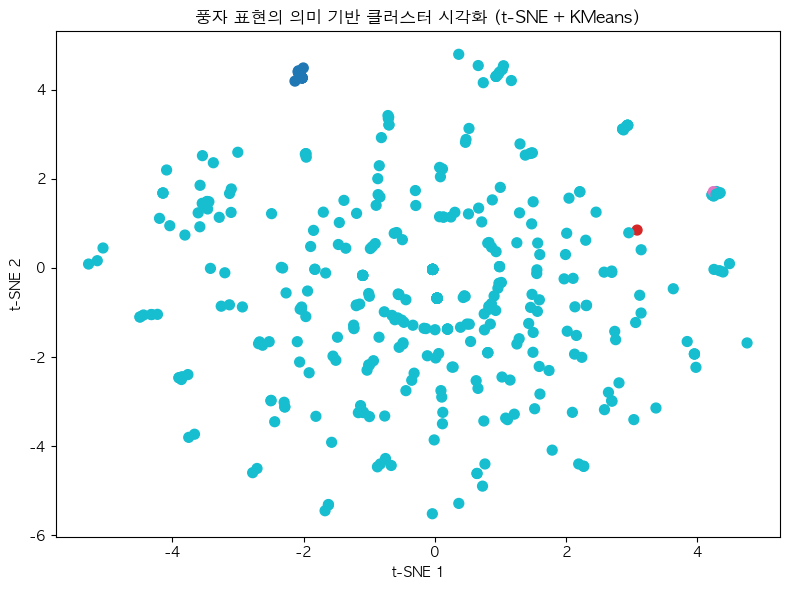

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# 토큰들을 하나로 모아 벡터화
corpus = df_s3_satire["joined"].tolist()
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)

# 차원 축소 + 클러스터링
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

kmeans = KMeans(n_clusters=4, random_state=42).fit(X.toarray())
labels = kmeans.labels_

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', s=50)
plt.title("풍자 표현의 의미 기반 클러스터 시각화 (t-SNE + KMeans)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()



의미가 겹치는 표현들이 있는지 확인

In [ ]:
import numpy as np

# 가장 오른쪽 끝에 있는 점 찾기 (예: t-SNE 1 축 기준)
furthest_idx = np.argmax(X_embedded[:, 0])  # 또는 X_embedded[:, 1] 도 가능

# 해당 문장과 군집 확인
representative_sentence = df_s3_satire.iloc[furthest_idx]["문장내용"]
cluster_label = kmeans.labels_[furthest_idx]

print(f"🔥 가장 튀어나온 문장 (클러스터 {cluster_label}):\n{representative_sentence}")


🔥 가장 튀어나온 문장 (클러스터 3):
재작년인가는 좀 그럴 듯한 과부 하나를 얻어 바로 집 옆집을 사가지고 치가를 시키면서 쑬쑬이 탈없이 1년 넘겨 이태 가까이 재미를 본 일이 있었읍니다.


시계열분석

<Figure size 1200x600 with 0 Axes>

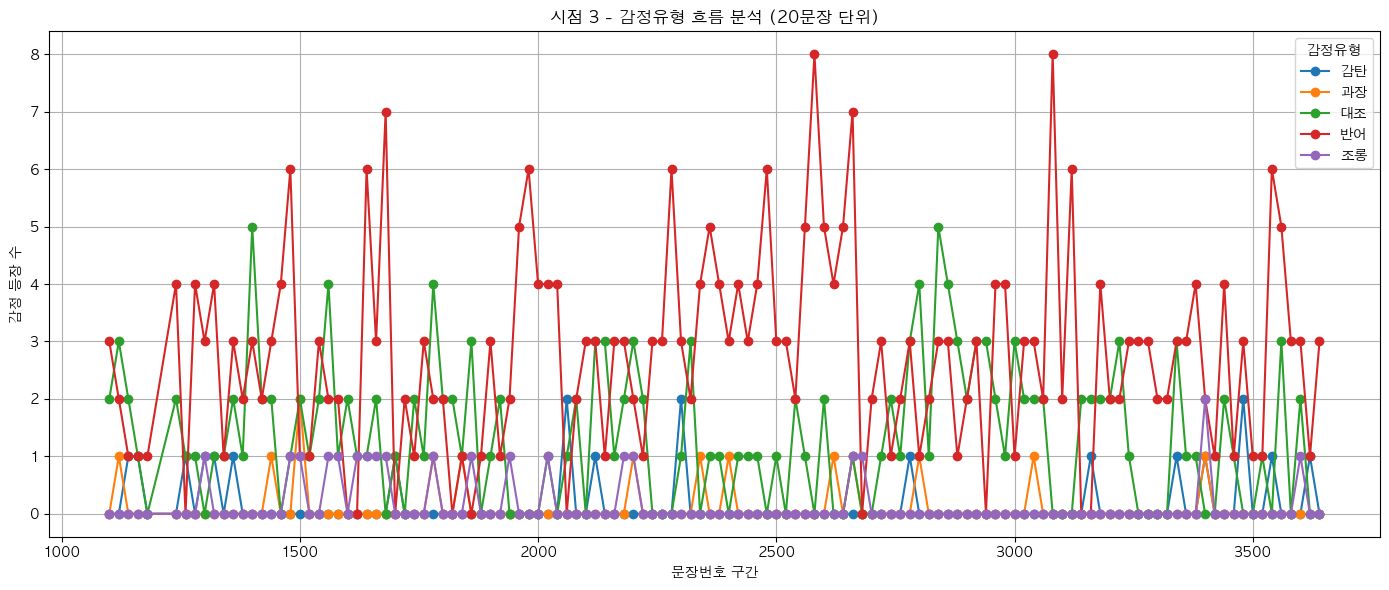

In [ ]:
import matplotlib.pyplot as plt

# 시점 3에서 감정유형 흐름 분석용 데이터
df_s3 = df[(df["문장번호"] >= 1101) & (df["문장번호"] <= 3654)].dropna(subset=["감정유형"])

# 감정유형 축소 처리 (복합 레이블 분리)
df_s3["감정단일"] = df_s3["감정유형"].apply(lambda x: x.split(",")[0].strip())

# 문장번호를 구간으로 나누기 (예: 20문장 단위)
df_s3["문장구간"] = (df_s3["문장번호"] // 20) * 20

# 구간별 감정 분포 계산
emotion_by_section = df_s3.groupby(["문장구간", "감정단일"]).size().unstack(fill_value=0)

# 선그래프 시각화
plt.figure(figsize=(12, 6))
emotion_by_section.plot(kind='line', marker='o', figsize=(14, 6))
plt.title("시점 3 - 감정유형 흐름 분석 (20문장 단위)")
plt.xlabel("문장번호 구간")
plt.ylabel("감정 등장 수")
plt.legend(title="감정유형")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 시점 3 후반부에서 반어 문장 필터링
df_s3_banuhigh = df[(df["문장번호"] >= 3200) & 
                    (df["문장번호"] <= 3600) & 
                    (df["감정유형"].str.contains("반어", na=False))]

# 문장번호 순으로 상위 10개 확인
df_s3_banuhigh[["문장번호", "문장내용"]].head(10)


,문장번호,문장내용
3199,3200,생긴 거란 역시 별수 없고 까칠한 게 갓 에나 논 고양이새끼 여대치게 어설펐읍니다.
3211,3212,하면서 머리 쓸던 팔로 허리를 그러안았 읍니다.
3213,3214,"이번 아이는 서울 태생이라 그런지 좀더 영악스럽게 ""이 영감이 왜 이 모양야?"
3221,3222,그러나 그러는 족족 실연의 쓴 술잔이 아니라
3223,3224,대단히 비참한 노릇입니다.
3244,3245,과연
3256,3257,그래 시골 계집애를 섬뻑 데려오지 못 하던것인데
3257,3258,그러나 이번 춘심이한테까지 낭패를 보고서도 종시 그런 주저를 하겠느냐 하면
3259,3260,그러니 일변 생각 하면 춘 심이의 소임이 매우 중대하고도 미묘한 의의를 가졌다고 할...
3265,3266,그런 것 저런 것 속으로 가늠을 해보면서


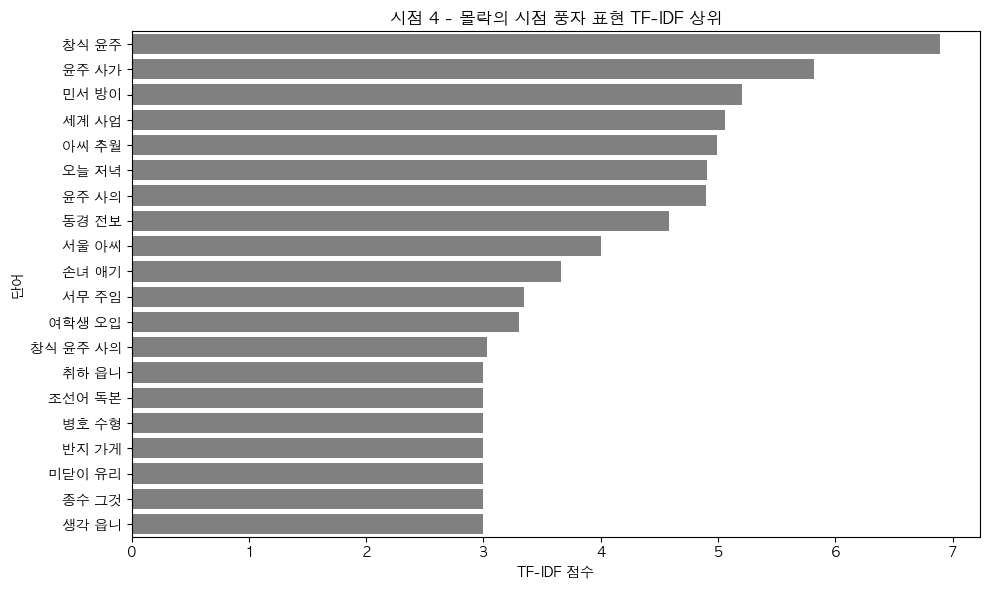

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어 확장
custom_stopwords = stopwords.union(set(["윤직", "영감", "양복", "신사", "그놈", "그자", "그년"]))

def clean_noun_tokens(text):
    tokens = okt.pos(text, stem=True)
    return [word for word, tag in tokens if tag == "Noun" and word not in custom_stopwords]

# 시점 4 범위 설정
s4_start, s4_end = 3655, df["문장번호"].max()
df_s4 = df[(df["문장번호"] >= s4_start) & (df["문장번호"] <= s4_end)].dropna(subset=["문장내용"])

# 명사 기반 토큰화
df_s4["tokens"] = df_s4["문장내용"].apply(clean_noun_tokens)
df_s4["joined"] = df_s4["tokens"].apply(lambda x: " ".join(x))
df_s4 = df_s4[df_s4["joined"].str.strip() != ""]

# TF-IDF 벡터라이저
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=100)
X = vectorizer.fit_transform(df_s4["joined"])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 상위 키워드 시각화
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="gray")
plt.title("시점 4 - 몰락의 시점 풍자 표현 TF-IDF 상위")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()


In [ ]:
# 상위 TF-IDF 단어 리스트
top_keywords = list(tfidf_df.sum().sort_values(ascending=False).head(20).index)

# 직접 분류를 위한 출력 (붙여넣고 분류 작성)
for i, word in enumerate(top_keywords, 1):
    print(f"{i}. {word}")


1. 창식 윤주
2. 윤주 사가
3. 민서 방이
4. 세계 사업
5. 아씨 추월
6. 오늘 저녁
7. 윤주 사의
8. 동경 전보
9. 서울 아씨
10. 손녀 애기
11. 서무 주임
12. 여학생 오입
13. 창식 윤주 사의
14. 취하 읍니
15. 조선어 독본
16. 병호 수형
17. 반지 가게
18. 미닫이 유리
19. 종수 그것
20. 생각 읍니
